In [1]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings

warnings.filterwarnings('ignore')


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
pd.set_option('display.width', 500)
pd.set_option('display.expand_frame_repr', False)

Reading the data

In [3]:
train = pd.read_csv('train 2.csv', parse_dates=['date'])
test = pd.read_csv('test.csv', parse_dates=['date'])

df = pd.concat([train, test], sort=False)

Data Analysis

In [4]:
df.shape

(958000, 5)

In [5]:
df.head()

date  store  item  sales  id
0 2013-01-01      1     1   13.0 NaN
1 2013-01-02      1     1   11.0 NaN
2 2013-01-03      1     1   14.0 NaN
3 2013-01-04      1     1   13.0 NaN
4 2013-01-05      1     1   10.0 NaN

In [6]:
df.tail()

date  store  item  sales       id
44995 2018-03-27     10    50    NaN  44995.0
44996 2018-03-28     10    50    NaN  44996.0
44997 2018-03-29     10    50    NaN  44997.0
44998 2018-03-30     10    50    NaN  44998.0
44999 2018-03-31     10    50    NaN  44999.0

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 958000 entries, 0 to 44999
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    958000 non-null  datetime64[ns]
 1   store   958000 non-null  int64         
 2   item    958000 non-null  int64         
 3   sales   913000 non-null  float64       
 4   id      45000 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 43.9 MB


In [8]:
df.describe().T

count                           mean                  min                  25%                  50%                  75%                  max           std
date     958000  2015-08-16 11:59:59.999999744  2013-01-01 00:00:00  2014-04-24 18:00:00  2015-08-16 12:00:00  2016-12-07 06:00:00  2018-03-31 00:00:00           NaN
store  958000.0                            5.5                  1.0                  3.0                  5.5                  8.0                 10.0      2.872283
item   958000.0                           25.5                  1.0                 13.0                 25.5                 38.0                 50.0     14.430877
sales  913000.0                      52.250287                  0.0                 30.0                 47.0                 70.0                231.0     28.801144
id      45000.0                        22499.5                  0.0             11249.75              22499.5             33749.25              44999.0  12990.525394

In [9]:
df.isnull().sum()

date          0
store         0
item          0
sales     45000
id       913000
dtype: int64

In [10]:
df["date"].min(), df["date"].max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2018-03-31 00:00:00'))

In [11]:
df.groupby(["store", "item"]).agg({"sales": ["sum", "mean", "median", "std", "count"]})

sales                                   
                 sum       mean median        std count
store item                                             
1     1      36468.0  19.971522   19.0   6.741022  1826
      2      97050.0  53.148959   52.0  15.005779  1826
      3      60638.0  33.208105   33.0  10.072529  1826
      4      36440.0  19.956188   20.0   6.640618  1826
      5      30335.0  16.612815   16.0   5.672102  1826
...              ...        ...    ...        ...   ...
10    46    120601.0  66.046550   65.0  18.114991  1826
      47     45204.0  24.755750   24.0   7.924820  1826
      48    105570.0  57.814896   57.0  15.898538  1826
      49     60317.0  33.032311   32.0  10.091610  1826
      50    135192.0  74.037240   73.0  19.937566  1826

[500 rows x 5 columns]

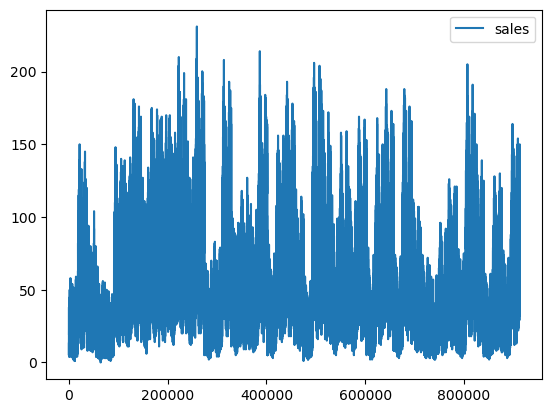

In [12]:
df[["sales"]].plot()
plt.show(block=True)

Time Series usually consist of three components: 

* *trend* component
* *seasonality* component
* *residual* (*noise*) component

Here we can see mostly seasonality component

Feature Engineering

In [13]:
df['year'] = df.date.dt.year
df['month'] = df.date.dt.month
df['quarter_of_year'] = df.date.dt.quarter
df['week_of_year'] = df.date.dt.isocalendar().week
df['day_of_year'] = df.date.dt.dayofyear
df['day_of_month'] = df.date.dt.day
df['day_of_week'] = df.date.dt.dayofweek
df["is_wknd"] = df.date.dt.weekday // 5
df['is_month_start'] = df.date.dt.is_month_start.astype(int)
df['is_month_end'] = df.date.dt.is_month_end.astype(int)

Lag/Shifted Features

In [14]:
df.sort_values(by=['store', 'item', 'date'], axis=0, inplace=True)

In [15]:
pd.DataFrame({"sales": df["sales"].values[0:10],
              "lag1": df["sales"].shift(1).values[0:10],
              "lag2": df["sales"].shift(2).values[0:10],
              "lag3": df["sales"].shift(3).values[0:10],
              "lag4": df["sales"].shift(4).values[0:10]})

sales  lag1  lag2  lag3  lag4
0   13.0   NaN   NaN   NaN   NaN
1   11.0  13.0   NaN   NaN   NaN
2   14.0  11.0  13.0   NaN   NaN
3   13.0  14.0  11.0  13.0   NaN
4   10.0  13.0  14.0  11.0  13.0
5   12.0  10.0  13.0  14.0  11.0
6   10.0  12.0  10.0  13.0  14.0
7    9.0  10.0  12.0  10.0  13.0
8   12.0   9.0  10.0  12.0  10.0
9    9.0  12.0   9.0  10.0  12.0

In [16]:
df.groupby(["store", "item"])['sales'].head()

0         13.0
1         11.0
2         14.0
3         13.0
4         10.0
          ... 
911174    33.0
911175    37.0
911176    46.0
911177    51.0
911178    41.0
Name: sales, Length: 2500, dtype: float64

In [17]:
df.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(1))

0         NaN
1        13.0
2        11.0
3        14.0
4        13.0
         ... 
44995     NaN
44996     NaN
44997     NaN
44998     NaN
44999     NaN
Name: sales, Length: 958000, dtype: float64

In [18]:
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["store", "item"])['sales'].transform(
            lambda x: x.shift(lag))
    return dataframe

In [19]:
df = lag_features(df, [1, 7, 14, 30, 90, 180, 365, 546, 730])

Rolling Mean Features

In [20]:
pd.DataFrame({"sales": df["sales"].values[0:10],
              "roll2": df["sales"].shift(1).rolling(window=2).mean().values[0:10],
              "roll3": df["sales"].shift(1).rolling(window=3).mean().values[0:10],
              "roll5": df["sales"].shift(1).rolling(window=5).mean().values[0:10]})

sales  roll2      roll3  roll5
0   13.0    NaN        NaN    NaN
1   11.0    NaN        NaN    NaN
2   14.0   12.0        NaN    NaN
3   13.0   12.5  12.666667    NaN
4   10.0   13.5  12.666667    NaN
5   12.0   11.5  12.333333   12.2
6   10.0   11.0  11.666667   12.0
7    9.0   11.0  10.666667   11.8
8   12.0    9.5  10.333333   10.8
9    9.0   10.5  10.333333   10.6

In [21]:
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["store", "item"])['sales']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean())
    return dataframe

In [22]:
df = roll_mean_features(df, [30, 365, 546])

Exponentially Weighted Mean Features
$$
y_0 = x_0
$$
$$
y_t = (1-\alpha)y_{t-1} + \alpha x_t
$$

In [23]:
pd.DataFrame({"sales": df["sales"].values[0:10],
              "roll2": df["sales"].shift(1).rolling(window=2).mean().values[0:10],
              "ewm099": df["sales"].shift(1).ewm(alpha=0.99).mean().values[0:10],
              "ewm095": df["sales"].shift(1).ewm(alpha=0.95).mean().values[0:10],
              "ewm07": df["sales"].shift(1).ewm(alpha=0.7).mean().values[0:10],
              "ewm02": df["sales"].shift(1).ewm(alpha=0.1).mean().values[0:10]})

sales  roll2     ewm099     ewm095      ewm07      ewm02
0   13.0    NaN        NaN        NaN        NaN        NaN
1   11.0    NaN  13.000000  13.000000  13.000000  13.000000
2   14.0   12.0  11.019802  11.095238  11.461538  11.947368
3   13.0   12.5  13.970201  13.855107  13.287770  12.704797
4   10.0   13.5  13.009702  13.042750  13.084686  12.790637
5   12.0   11.5  10.030097  10.152137  10.920146  12.109179
6   10.0   11.0  11.980301  11.907607  11.676595  12.085878
7    9.0   11.0  10.019803  10.095380  10.502722  11.686057
8   12.0    9.5   9.010198   9.054769   9.450748  11.214433
9    9.0   10.5  11.970102  11.852738  11.235259  11.342672

In [24]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

In [25]:
alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [90, 180, 270, 365, 546, 728]

In [26]:
df = ewm_features(df, alphas, lags)

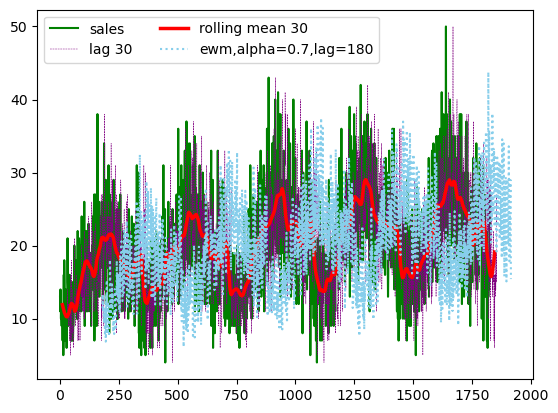

In [47]:
sample_df = df[(df['store'] == 1) & (df['item'] == 1)].sort_values('date')
sample_df["sales"].reset_index(drop=True).plot(label='sales', color='green')
sample_df["sales_lag_30"].reset_index(drop=True).plot(label='lag 30', linestyle='--', linewidth=0.35, color='purple')
sample_df["sales_roll_mean_30"].reset_index(drop=True).plot(label='rolling mean 30', linewidth=2.5, color='red')
sample_df["sales_ewm_alpha_07_lag_180"].reset_index(drop=True).plot(label='ewm,alpha=0.7,lag=180', linestyle=':', color='skyblue')
plt.legend(ncol=2);

One-Hot Encoding

In [48]:
df = pd.get_dummies(df, columns=['store', 'item', 'day_of_week', 'month'])

Model

### Symmetric MAPE (SMAPE)
$$
MAPE(y, \hat{y}) = \frac{1}{N}\sum_{i=1}^N |\frac{\hat{y}-y}{y}|\cdot 100\%
$$
$$
SMAPE(y, \hat{y}) = \frac{1}{N}\sum_{i=1}^N \frac{|\hat{y}-y|}{\frac{1}{2}|y| + \frac{1}{2}|\hat{y}|}\cdot 100\%
$$

In [49]:
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val


def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(preds, labels)
    return 'SMAPE', smape_val, False

In [50]:
train = df.loc[(df["date"] < "2017-01-01"), :]

val = df.loc[(df["date"] >= "2017-01-01") & (df["date"] < "2017-04-01"), :]

cols = [col for col in train.columns if col not in ['date', 'id', "sales", "year"]]

Y_train = train['sales']
X_train = train[cols]

Y_val = val['sales']
X_val = val[cols]

Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((730500,), (730500, 128), (45000,), (45000, 128))

Time Series Model with LightGBM

In [51]:
lgb_params = {'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 10000,
              'nthread': -1}

In [52]:
lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

In [53]:
model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  feval=lgbm_smape,
                  callbacks=[lgb.early_stopping(stopping_rounds=200), lgb.log_evaluation(100)])

Training until validation scores don't improve for 200 rounds
[100]	training's l2: 88.6847	training's SMAPE: 17.3501	valid_1's l2: 73.7789	valid_1's SMAPE: 17.6715
[200]	training's l2: 64.4648	training's SMAPE: 14.3601	valid_1's l2: 58.3648	valid_1's SMAPE: 14.9466
[300]	training's l2: 60.7413	training's SMAPE: 13.8311	valid_1's l2: 55.2978	valid_1's SMAPE: 14.4034
[400]	training's l2: 59.1237	training's SMAPE: 13.6398	valid_1's l2: 53.8619	valid_1's SMAPE: 14.198
[500]	training's l2: 58.1182	training's SMAPE: 13.5298	valid_1's l2: 52.9839	valid_1's SMAPE: 14.0915
[600]	training's l2: 57.3872	training's SMAPE: 13.4563	valid_1's l2: 52.4115	valid_1's SMAPE: 14.0263
[700]	training's l2: 56.8104	training's SMAPE: 13.4007	valid_1's l2: 51.9331	valid_1's SMAPE: 13.9735
[800]	training's l2: 56.3386	training's SMAPE: 13.3531	valid_1's l2: 51.457	valid_1's SMAPE: 13.9222
[900]	training's l2: 55.9242	training's SMAPE: 13.3112	valid_1's l2: 50.999	valid_1's SMAPE: 13.8737
[1000]	training's l2: 5

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8100]	training's l2: 50.5059	training's SMAPE: 12.7931	valid_1's l2: 47.6556	valid_1's SMAPE: 13.4651
Early stopping, best iteration is:
[7988]	training's l2: 50.5349	training's SMAPE: 12.7951	valid_1's l2: 47.6546	valid_1's SMAPE: 13.465


In [54]:
y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)

In [55]:
smape(y_pred_val, Y_val)

13.464997820641972

In [56]:
def plot_lgb_importances(model, plot=False, num=10):
    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show(block=True)
    else:
        print(feat_imp.head(num))
    return feat_imp

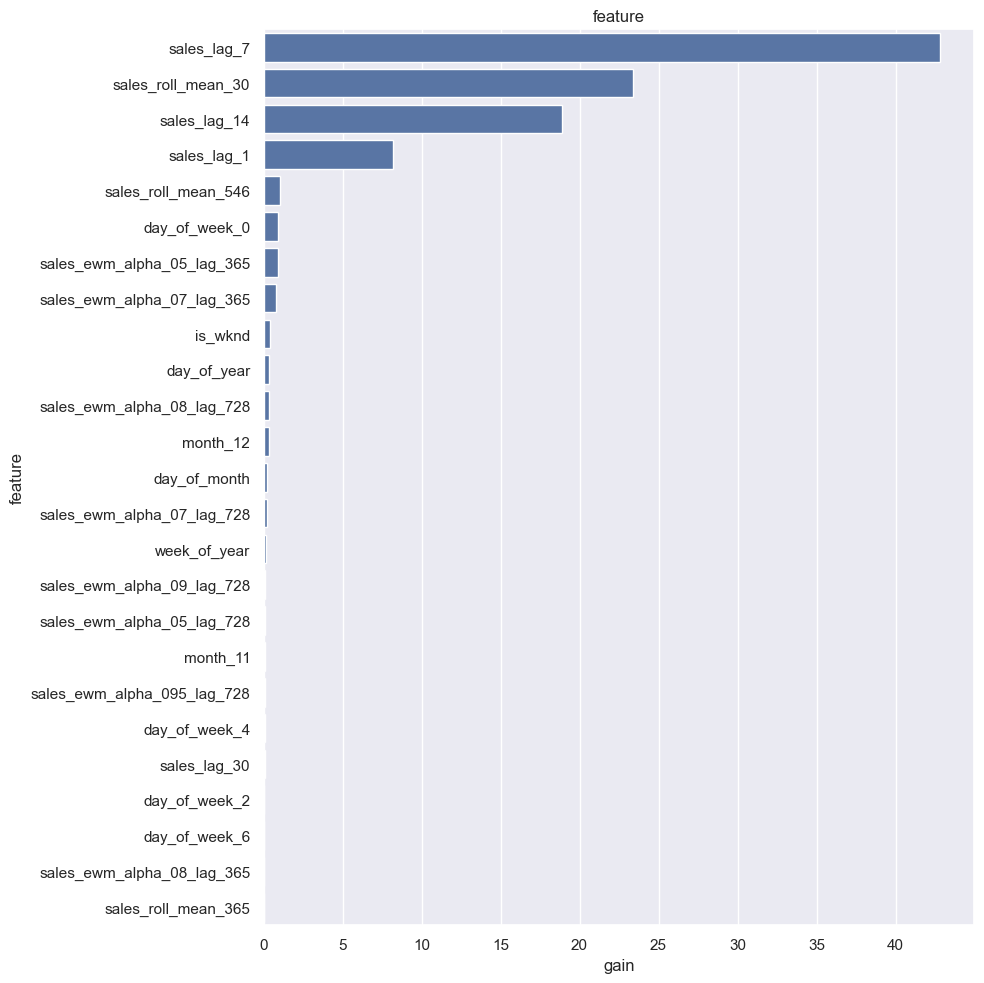

feature  split       gain
8            sales_lag_7   6719  42.826653
16    sales_roll_mean_30   4459  23.369469
9           sales_lag_14   5608  18.865656
7            sales_lag_1   5902   8.181778
18   sales_roll_mean_546   7601   1.057300
..                   ...    ...        ...
61                item_3      1   0.000004
88               item_30      1   0.000003
90               item_32      0   0.000000
100              item_42      0   0.000000
84               item_26      0   0.000000

[128 rows x 3 columns]

In [57]:
plot_lgb_importances(model, num=30, plot=True)

In [58]:
feat_imp = plot_lgb_importances(model, num=200)

low_importance = feat_imp[feat_imp["gain"] <= 0.005]["feature"].values

dff = df.drop(low_importance, axis=1)

cols_dff = [col for col in dff.columns if col not in ['date', 'id', "sales", "year"]]

                 feature  split       gain
8            sales_lag_7   6719  42.826653
16    sales_roll_mean_30   4459  23.369469
9           sales_lag_14   5608  18.865656
7            sales_lag_1   5902   8.181778
18   sales_roll_mean_546   7601   1.057300
..                   ...    ...        ...
61                item_3      1   0.000004
88               item_30      1   0.000003
90               item_32      0   0.000000
100              item_42      0   0.000000
84               item_26      0   0.000000

[128 rows x 3 columns]


Final Model

In [59]:
train = dff.loc[~df.sales.isna()]
Y_train = train['sales']
X_train = train[cols_dff]


test = dff.loc[df.sales.isna()]
X_test = test[cols_dff]

In [60]:
lgb_params = {'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'nthread': -1,
              "num_boost_round": model.best_iteration}

In [61]:
lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols_dff)

In [62]:
final_model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model.best_iteration)

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [42]:
test_preds = final_model.predict(X_test, num_iteration=model.best_iteration)

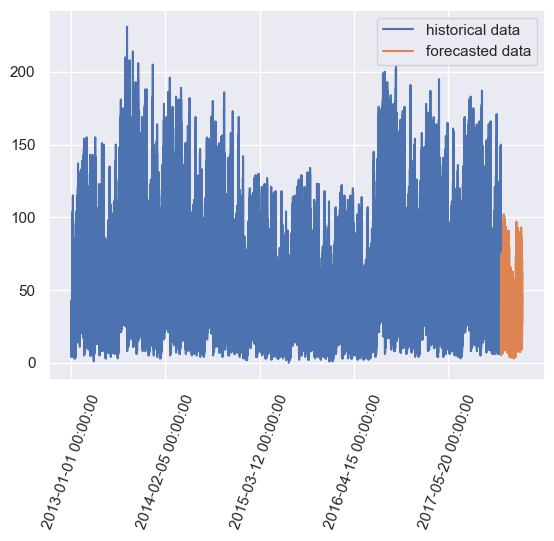

In [66]:
train_len = len(Y_train)
test_len = len(test_preds)
all_len = train_len + test_len
xticks_step = 200000

plt.plot(np.arange(train_len), Y_train, label="historical data")
plt.plot(np.arange(train_len, all_len), test_preds, label="forecasted data")
plt.legend()
plt.xticks(np.arange(0, all_len, xticks_step), df['date'].sort_values()[::xticks_step], rotation=70);